<a href="https://colab.research.google.com/github/rrsguim/PhD_Economics/blob/master/NN4BC/Logit_1df_US.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------------------------------------------------------------------
Copyright (c) 2020 Rafael Guimaraes

This work was done when I was at the University of California, Riverside, USA. 

It is part of my doctoral thesis in Economics at the Federal University of 

Rio Grande do Sul, Porto Alegre, Brazil.


See full material at https://github.com/rrsguim/PhD_Economics

The code below, under the Apache License, was inspired by

*Building A Logistic Regression in Python*,

Copyright 2017 Susan Li

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

-------------------------------------------------------------------------

# Transfer Learning for Business Cycle Identification

##Setup

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

####US data

In [ ]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/NN4BC/TL4BC_US_data.csv')

In [ ]:
raw_data.index = raw_data['DATE']
drop_DATE = raw_data.pop('DATE')
raw_data.index = pd.to_datetime(raw_data.index,infer_datetime_format=True)
raw_data.index = raw_data.index.to_period("Q")

#### Transform the features into log first difference.

In [ ]:
log_data = raw_data.copy()

log_data['GDP'] = np.log(log_data['GDP'])
log_data['Income'] = np.log(log_data['Income'])
log_data['Employment'] = np.log(log_data['Employment'])
log_data['Industry'] = np.log(log_data['Industry'])
log_data['Sales'] = np.log(log_data['Sales'])

In [ ]:
log_1df = log_data.copy()

log_1df['GDP'] = log_data['GDP'] - log_data['GDP'].shift(1)
log_1df['Income'] = log_data['Income'] - log_data['Income'].shift(1)
log_1df['Employment'] = log_data['Employment'] - log_data['Employment'].shift(1)
log_1df['Industry'] = log_data['Industry'] - log_data['Industry'].shift(1)
log_1df['Sales'] = log_data['Sales'] - log_data['Sales'].shift(1)

In [ ]:
log_1df = log_1df[1:]
log_1df.tail()

,GDP,Income,Employment,Industry,Sales,NBER
DATE,,,,,,
2018Q4,0.002710,0.005645,0.004112,0.009481,0.003436,0
2019Q1,0.007623,0.009776,0.001403,-0.004879,0.014956,0
2019Q2,0.004985,0.004228,0.000904,-0.005700,-0.005293,0
2019Q3,0.005204,0.001736,0.007021,0.002808,0.009172,0
2019Q4,0.005261,0.005844,0.001715,0.000877,0.000543,0


####Data exploration

#### Inspect pre-processed data

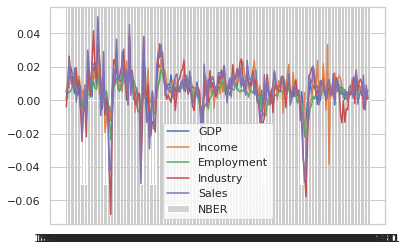

In [ ]:
plt.plot(drop_DATE[1:], log_1df['GDP'], label='GDP')
plt.plot(drop_DATE[1:], log_1df['Income'], label='Income')
plt.plot(drop_DATE[1:], log_1df['Employment'], label='Employment')
plt.plot(drop_DATE[1:], log_1df['Industry'], label='Industry')
plt.plot(drop_DATE[1:], log_1df['Sales'], label='Sales')
plt.bar(drop_DATE, raw_data['NBER']/-20, width=1, linewidth=1, align='center', color="lightgray", label='NBER') 
plt.legend()
plt.show()

##### Examine the class label imbalance

In [ ]:
log_1df['NBER'].value_counts()

0    184
1     27
Name: NBER, dtype: int64

In [ ]:
neg, pos = np.bincount(log_1df['NBER']) 
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 211
    Positive: 27 (12.80% of total)



In [ ]:
log_1df.groupby('NBER').mean()

,GDP,Income,Employment,Industry,Sales
NBER,,,,,
0,0.008561,0.008683,0.005244,0.009218,0.009766
1,-0.004858,-0.005365,-0.006999,-0.021477,-0.015869


#####Over-sampling using SMOTE to have a balanced training dataset

In [ ]:
X = log_1df.loc[:, log_1df.columns != 'NBER']
y = log_1df.loc[:, log_1df.columns == 'NBER']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of expansions in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of contractions",len(os_data_y[os_data_y['y']==1]))
print("Proportion of expansion data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of contraction data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  256
Number of expansions in oversampled data 128
Number of contractions 128
Proportion of expansion data in oversampled data is  0.5
Proportion of contraction data in oversampled data is  0.5


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

##Model

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.086585
         Iterations 11
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.774     
Dependent Variable: NBER             AIC:              46.5387   
Date:               2020-11-18 16:38 BIC:              63.2980   
No. Observations:   211              Log-Likelihood:   -18.269   
Df Model:           4                LL-Null:          -80.706   
Df Residuals:       206              LLR p-value:      4.8566e-26
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     11.0000                                      
-----------------------------------------------------------------
              Coef.   Std.Err.    z    P>|z|    [0.025    0.975] 
-----------------------------------------------------------------
GDP         -375.5070 105.5113 -3.5589 0.0004 -582.3054 -168.7086
Income      -144.1773  50.8709 -2.8342 0.0046 -243.8824  -44.4722

#####Remove Sales because of its p-value and re-run the model

In [ ]:
cols=['GDP', 'Income', 'Employment', 'Industry'] 
X=os_data_X[cols]
y=os_data_y['y']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.053123
         Iterations 13
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.923     
Dependent Variable: y                AIC:              35.1990   
Date:               2020-11-18 16:38 BIC:              49.3797   
No. Observations:   256              Log-Likelihood:   -13.600   
Df Model:           3                LL-Null:          -177.45   
Df Residuals:       252              LLR p-value:      1.0081e-70
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     13.0000                                      
-----------------------------------------------------------------
              Coef.   Std.Err.    z    P>|z|    [0.025    0.975] 
-----------------------------------------------------------------
GDP         -601.0870 187.0363 -3.2137 0.0013 -967.6713 -234.5027
Income      -242.2651  75.5920 -3.2049 0.0014 -390.4226  -94.1076

####Logistic Regression Model Fitting

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##Results

####Predicting the test set results and calculating the accuracy

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.58


####Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[36  0]
 [32  9]]


In [ ]:
print("True negative: ",confusion_matrix[0,0]) 
print("False positive: ",confusion_matrix[0,1]) 
print("False negative: ",confusion_matrix[1,0]) 
print("True positive: ",confusion_matrix[1,1]) 

True negative:  36
False positive:  0
False negative:  32
True positive:  9


####Compute precision, recall, F-measure and support

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      1.00      0.69        36
           1       1.00      0.22      0.36        41

    accuracy                           0.58        77
   macro avg       0.76      0.61      0.53        77
weighted avg       0.78      0.58      0.52        77



####ROC curve

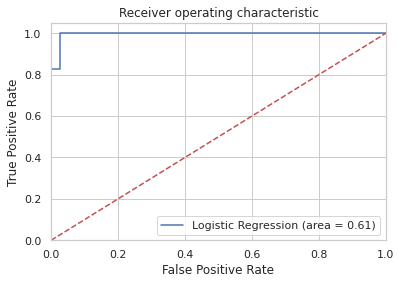

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()